FINANCE PROJECT - 1
TOPIC: 
- Built a basic backtesting framework to evaluate moving average crossover strategies on equity data.
- Incorporated trade logs, performance metrics (Sharpe, max drawdown), and plotted equity curves using matplotlib.

In [1]:
#import required libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [22]:
#Create a function to download historical data of the stock
def get_stock_data (ticker,start,end):
    data=yf.download(ticker,start,end)
    data=data[['Close']]
    data.dropna(inplace=True)
    return data

In [23]:
#Strategy Logic - Moving Average Crossover ===
def generate_signal(data,short_window=50,long_window=200):
    for (attr,ticker) in data.columns:
        #print(ticker)
        data[('SMA50',ticker)]=data[('Close',ticker)].rolling(window=short_window).mean()
        data[('SMA200',ticker)]=data[('Close',ticker)].rolling(window=long_window).mean()
        data[('Signal',ticker)]=0
        data.loc[data.index[short_window:],('Signal',ticker)]=np.where(data.loc[data.index[short_window:],('SMA50',ticker)]>data.loc[data.index[short_window:],('SMA200',ticker)],1,0)
        data[('Position',ticker)]=data[('Signal',ticker)].diff()
    return data

In [24]:
def backtest_strategy(df, initial_capital=100000):
    ticker_list=list(set([ticker for (attr,ticker) in df.columns]))

    positions=pd.DataFrame(index=df.index).fillna(0)
    portfolio=pd.DataFrame(index=df.index).fillna(0)


    for ticker in ticker_list:
        positions[('#SHARES',ticker)]=df[('Position',ticker)]*100
    for ticker in ticker_list:
        portfolio[('#SHARES HELD',ticker)]=df[('Signal',ticker)]*100
    for ticker in ticker_list:
        portfolio[('Holdings',ticker)]=portfolio[('#SHARES HELD',ticker)]*df[('Close',ticker)]
    
    portfolio.columns=pd.MultiIndex.from_tuples(portfolio.columns,name=['Attr','Ticker'])

    positions.columns=pd.MultiIndex.from_tuples(positions.columns,name=['Attr','Ticker'])

    portfolio[('Holdings','Total')]=portfolio.xs('Holdings', axis=1, level=0).sum(axis=1)

    portfolio[('Total','Trade Value')]=0
    for ticker in ticker_list:
        portfolio[('Total','Trade Value')]+=df[('Close',ticker)]*positions[('#SHARES',ticker)]

    portfolio[('Total','Cash')]=initial_capital-portfolio[('Total','Trade Value')].cumsum()
    portfolio[('Portfolio','Total Value')]=portfolio[('Holdings','Total')]+portfolio[('Total','Cash')]
    portfolio[('Net','Return')]=(portfolio[('Portfolio','Total Value')]-initial_capital)*100/initial_capital
    return df, portfolio

In [25]:
def calculate_performance(portfolio):
    sharpe_ratio=np.sqrt(252)*(portfolio[('Net','Return')].mean()/portfolio[('Net','Return')].std())
    cumulative_return=(portfolio[('Portfolio','Total Value')][-1]-portfolio[('Portfolio','Total Value')][1])/portfolio[('Portfolio','Total Value')][1]
    drawdown = (portfolio[('Portfolio','Total Value')] /portfolio[('Portfolio','Total Value')].cummax()) - 1
    max_drawdown = drawdown.min()
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Cumulative Return': cumulative_return,
        'Max Drawdown': max_drawdown
    }

In [26]:
def trade_log(df):
    ticker_list=list(set(list(ticker for (attr,ticker) in df.columns)))
    #ticker_list
    trades=df[['Close','Position']]
    trades['Abs Trade']=trades['Position'].abs().sum(axis=1)
    trade_log=trades[trades['Abs Trade'].notnull() & trades['Abs Trade'] !=0]
    for ticker in ticker_list:
        trade_log[('Trade_Type',ticker)]=trade_log[('Position',ticker)].apply (lambda x: 'BUY' if x==1 else 'SELL' if x==-1 else 'HOLD')
    del(trade_log['Abs Trade'])
    return trade_log

In [27]:
def plot_equity_curve(data):
    plt.figure(figsize=(14, 6))
    plt.plot(portfolio[('Portfolio','Total Value')], label='Equity Curve')
    ticker_list=list(set(list([ticker for attr,ticker in df.columns])))
    for ticker in ticker_list:
        plt.plot(df[('Close',ticker)], label=ticker, alpha=0.7)
    plt.title('Portfolio Value Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

C:\Users\gbanwat\AppData\Local\Temp\ipykernel_27396\2788382613.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download(ticker,start,end)
[*********************100%***********************]  2 of 2 completed
C:\Users\gbanwat\AppData\Local\Temp\ipykernel_27396\1912827823.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return=(portfolio[('Portfolio','Total Value')][-1]-portfolio[('Portfolio','Total Value')][1])/portfolio[('Portfolio','Total Value')][1]
C:\Users\gbanwat\AppData\Local\Temp\ipykernel_27396\2993520157.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta


Performance Metrics:
Sharpe Ratio: 11.1535
Cumulative Return: 0.4318
Max Drawdown: -0.0539

Sample Trade Log:
Price           Close            Position      Trade_Type      
Ticker           MSFT        NRG     MSFT  NRG        NRG  MSFT
Date                                                           
2004-09-17  17.063099   9.805714      1.0  1.0        BUY   BUY
2005-03-28  16.780949  13.005277     -1.0  0.0       HOLD  SELL
2005-08-11  18.969749  14.439430      1.0  0.0       HOLD   BUY
2006-05-12  16.267817  17.563709     -1.0  0.0       HOLD  SELL
2006-09-28  19.383877  17.059309      1.0  0.0       HOLD   BUY


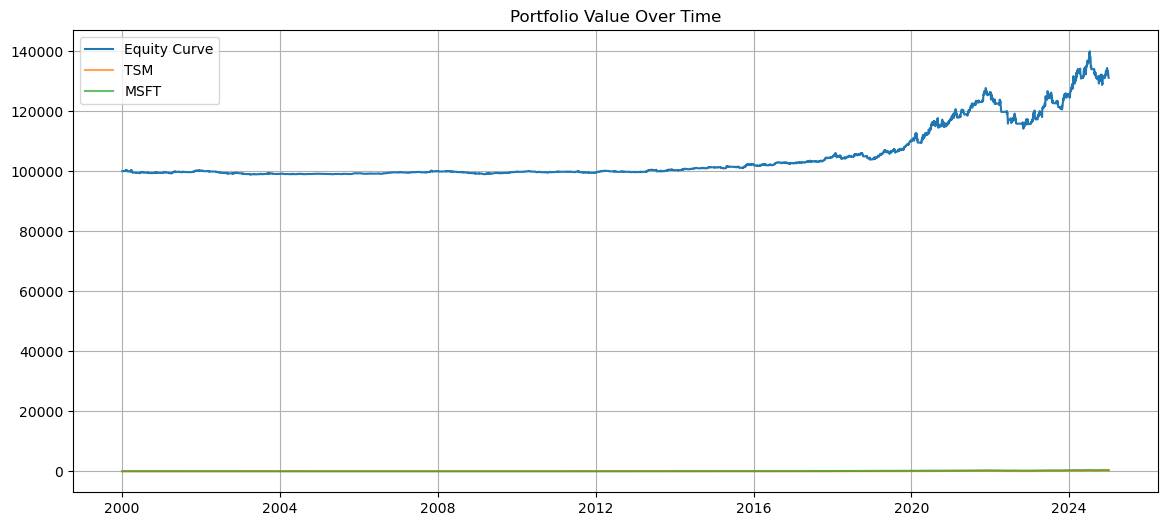

In [21]:
def main():
    ticker=['MSFT','NRG']
    start_date='2000-01-01'
    end_date='2025-01-01'
    data=get_stock_data(ticker,start_date,end_date)
    data=generate_signal(data)
    data,portfolio=backtest_strategy(data)
    metrics = calculate_performance(portfolio)
    tradelog = trade_log(data)
    print("\nPerformance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    print("\nSample Trade Log:")
    print(tradelog.head())

    plot_equity_curve(data)


if __name__ == "__main__":
    main()

In [30]:
df.dtypes

Price     Ticker
Close     MSFT      float64
          TSM       float64
SMA50     MSFT      float64
SMA200    MSFT      float64
Signal    MSFT        int64
Position  MSFT      float64
SMA50     TSM       float64
SMA200    TSM       float64
Signal    TSM         int64
Position  TSM       float64
dtype: object